This notebook is based on the file [Synthetic Features and Outliers](https://colab.research.google.com/notebooks/mlcc/synthetic_features_and_outliers.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=syntheticfeatures-colab&hl=en), which is part of Google's [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/).

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Synthetic Features and Outliers

**Learning Objectives:**
  * Create a synthetic feature that is the ratio of two other features
  * Use this new feature as an input to a linear regression model
  * Improve the effectiveness of the model by identifying and clipping (removing) outliers out of the input data

Let's revisit our model from the previous First Steps with TensorFlow exercise. 

First, we'll import the California housing data into `DataFrame`:

## Setup

In [2]:
using Plots
gr()
using DataFrames
using TensorFlow
import CSV

sess=Session()

california_housing_dataframe = CSV.read("california_housing_train.csv", delim=",");
california_housing_dataframe[:median_house_value] /= 1000.0
california_housing_dataframe

17000×9 DataFrames.DataFrame. Omitted printing of 5 columns
│ Row   │ longitude │ latitude │ housing_median_age │ total_rooms │
├───────┼───────────┼──────────┼────────────────────┼─────────────┤
│ 1     │ -114.31   │ 34.19    │ 15.0               │ 5612.0      │
│ 2     │ -114.47   │ 34.4     │ 19.0               │ 7650.0      │
│ 3     │ -114.56   │ 33.69    │ 17.0               │ 720.0       │
│ 4     │ -114.57   │ 33.64    │ 14.0               │ 1501.0      │
│ 5     │ -114.57   │ 33.57    │ 20.0               │ 1454.0      │
│ 6     │ -114.58   │ 33.63    │ 29.0               │ 1387.0      │
│ 7     │ -114.58   │ 33.61    │ 25.0               │ 2907.0      │
│ 8     │ -114.59   │ 34.83    │ 41.0               │ 812.0       │
│ 9     │ -114.59   │ 33.61    │ 34.0               │ 4789.0      │
│ 10    │ -114.6    │ 34.83    │ 46.0               │ 1497.0      │
│ 11    │ -114.6    │ 33.62    │ 16.0               │ 3741.0      │
⋮
│ 16989 │ -124.21   │ 41.75    │ 20.0               │ 3810.0      │
│ 16990 │ -124.21   │ 40.75    │ 32.0               │ 1218.0      │
│ 16991 │ -124.22   │ 41.73    │ 28.0               │ 3003.0      │
│ 16992 │ -124.23   │ 41.75    │ 11.0               │ 3159.0      │
│ 16993 │ -124.23   │ 40.81    │ 52.0               │ 1112.0      │
│ 16994 │ -124.23   │ 40.54    │ 52.0               │ 2694.0      │
│ 16995 │ -124.25   │ 40.28    │ 32.0               │ 1430.0      │
│ 16996 │ -124.26   │ 40.58    │ 52.0               │ 2217.0      │
│ 16997 │ -124.27   │ 40.69    │ 36.0               │ 2349.0      │
│ 16998 │ -124.3    │ 41.84    │ 17.0               │ 2677.0      │
│ 16999 │ -124.3    │ 41.8     │ 19.0               │ 2672.0      │
│ 17000 │ -124.35   │ 40.54    │ 52.0               │ 1820.0      │

Next, we'll set up our input functions, and define the function for model training:

In [3]:
function create_batches(features, targets, steps, batch_size=5, num_epochs=0)
    
    if(num_epochs==0)
        num_epochs=ceil(batch_size*steps/length(features))
    end

    features_batches=Union{Float64, Missings.Missing}[]
    target_batches=Union{Float64, Missings.Missing}[]

    for i=1:num_epochs
        
        select=shuffle(1:length(features))
        
        append!(features_batches, features[select])
        append!(target_batches, targets[select])
    end
    
    return features_batches, target_batches 
end

create_batches (generic function with 3 methods)

In [4]:
function next_batch(features_batches, targets_batches, batch_size, iter)

    select=mod((iter-1)*batch_size+1, length(features_batches)):mod(iter*batch_size, length(features_batches));

    ds=features_batches[select];
    target=targets_batches[select];
    
    return ds, target
end
    

next_batch (generic function with 1 method)

In [5]:
function my_input_fn(features_batches, targets_batches, iter, batch_size=5, shuffle_flag=1):
    """Trains a linear regression model of one feature.
  
    Args:
      features: DataFrame of features
      targets: DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
                                          
    # Construct a dataset, and configure batching/repeating.
    ds, target = next_batch(features_batches, targets_batches, batch_size, iter)
    
    # Shuffle the data, if specified.
    if shuffle_flag==1
      select=shuffle(1:size(ds, 1));
        ds = ds[select,:]
        target = target[select, :]
    end
    
    # Return the next batch of data.
    return convert.(Float64,ds), convert.(Float64,target)
end

my_input_fn (generic function with 3 methods)

In [11]:
function train_model(learning_rate, steps, batch_size, input_feature=:total_rooms)
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `symbol` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = convert.(Float32,california_housing_dataframe[my_feature])
  my_label = :median_house_value
  targets = convert.(Float32,california_housing_dataframe[my_label])

  # Create feature columns.
  feature_columns = placeholder(Float32)
  target_columns = placeholder(Float32)
  
  # Create a linear regressor object.
  m=Variable(0.0)
  b=Variable(0.0)
  y=m.*feature_columns .+ b
  loss=reduce_sum((target_columns - y).^2)
  run(sess, global_variables_initializer())
  features_batches, targets_batches = create_batches(my_feature_data, targets, steps, batch_size)
    
  # Use gradient descent as the optimizer for training the model.
  #my_optimizer=train.minimize(train.GradientDescentOptimizer(learning_rate), loss)
  my_optimizer=(train.GradientDescentOptimizer(learning_rate))
  gvs = train.compute_gradients(my_optimizer, loss)
  capped_gvs = [(clip_by_norm(grad, 5.), var) for (grad, var) in gvs]
  my_optimizer = train.apply_gradients(my_optimizer,capped_gvs)
    
  # Set up to plot the state of our model's line each period.
  sample = california_housing_dataframe[rand(1:size(california_housing_dataframe,1), 300),:];
  p1=scatter(sample[my_feature], sample[my_label], title="Learned Line by Period", ylabel=my_label, xlabel=my_feature,color=:coolwarm)
  colors= [ColorGradient(:coolwarm)[i] for i in linspace(0,1, periods+1)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  println("Training model...")
  println("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in 1:periods
    # Train the model, starting from the prior state.
   for i=1:steps_per_period
    features, labels = my_input_fn(features_batches, targets_batches, convert(Int,(period-1)*steps_per_period+i), batch_size)
    run(sess, my_optimizer, Dict(feature_columns=>features, target_columns=>labels))
   end
    # Take a break and compute predictions.
    predictions = run(sess, y, Dict(feature_columns=> my_feature_data));    
        
    # Compute loss.
    mean_squared_error = mean((predictions- targets).^2)
    root_mean_squared_error = sqrt(mean_squared_error)
    # Occasionally print the current loss.
    println("  period ", period, ": ", root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    push!(root_mean_squared_errors, root_mean_squared_error)
    # Finally, track the weights and biases over time.
    
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = [0 maximum(sample[my_label])]
    weight = run(sess,m)
    bias = run(sess,b)          
    x_extents = (y_extents - bias) / weight    
    x_extents = max.(min.(x_extents, maximum(sample[my_feature])),
                           minimum(sample[my_feature]))    
    y_extents = weight .* x_extents .+ bias
    p1=plot!(x_extents', y_extents', color=colors[period], linewidth=2) 
 end

  predictions = run(sess, y, Dict(feature_columns=> my_feature_data)); 
  weight = run(sess,m)
  bias = run(sess,b)
    
  println("Model training finished.")

  # Output a graph of loss metrics over periods.
  p2=plot(root_mean_squared_errors, title="Root Mean Squared Error vs. Periods", ylabel="RMSE", xlabel="Periods")       
                
  # Output a table with calibration data.
  calibration_data = DataFrame()
  calibration_data[:predictions] = predictions
  calibration_data[:targets] = targets
  describe(calibration_data)

  println("Final RMSE (on training data): ", root_mean_squared_errors[end])
  println("Final Weight (on training data): ", weight)
  println("Final Bias (on training data): ", bias)
    
  return p1, p2, calibration_data   
end

train_model (generic function with 2 methods)

## Task 1: Try a Synthetic Feature

Both the `total_rooms` and `population` features count totals for a given city block.

But what if one city block were more densely populated than another? We can explore how block density relates to median house value by creating a synthetic feature that's a ratio of `total_rooms` and `population`.

In the cell below, we create a feature called `rooms_per_person`, and use that as the `input_feature` to `train_model()`.

In [7]:
california_housing_dataframe[:rooms_per_person] =(
    california_housing_dataframe[:total_rooms] ./ california_housing_dataframe[:population]);

In [14]:
p1, p2, calibration_data= train_model(
    0.05, # learning rate
    1000, # steps
    5, # batch size
    :rooms_per_person #feature
)

Training model...
RMSE (on training data):
  period 1: 174.73499015754794
  period 2: 134.71078976839658
  period 3: 125.55076328927971
  period 4: 126.57741465589378
  period 5: 126.25333063681862
  period 6: 126.96155073215469
  period 7: 126.46464736821247
  period 8: 127.36567810703599
  period 9: 126.96500792643184
  period 10: 129.1270898729325
Model training finished.


(Plot{Plots.GRBackend() n=11}, Plot{Plots.GRBackend() n=1}, 17000×2 DataFrames.DataFrame
│ Row   │ predictions │ targets │
├───────┼─────────────┼─────────┤
│ 1     │ 473.972     │ 66.9    │
│ 2     │ 564.655     │ 80.1    │
│ 3     │ 229.099     │ 85.7    │
│ 4     │ 283.821     │ 73.4    │
│ 5     │ 241.315     │ 65.5    │
│ 6     │ 222.183     │ 74.0    │
│ 7     │ 186.689     │ 82.4    │
│ 8     │ 229.33      │ 48.5    │
│ 9     │ 182.983     │ 58.4    │
│ 10    │ 210.19      │ 48.1    │
│ 11    │ 183.63      │ 86.5    │
⋮
│ 16989 │ 210.883     │ 66.9    │
│ 16990 │ 214.725     │ 58.1    │
│ 16991 │ 214.596     │ 78.3    │
│ 16992 │ 242.92      │ 73.2    │
│ 16993 │ 220.514     │ 50.8    │
│ 16994 │ 241.927     │ 106.7   │
│ 16995 │ 311.485     │ 76.1    │
│ 16996 │ 249.621     │ 111.4   │
│ 16997 │ 214.93      │ 79.0    │
│ 16998 │ 228.355     │ 103.6   │
│ 16999 │ 221.564     │ 85.8    │
│ 17000 │ 236.074     │ 94.6    │)

Final RMSE (on training data): 129.1270898729325
Final Weight (on training data): 72.72948312797806
Final Bias (on training data): 71.84641197969654


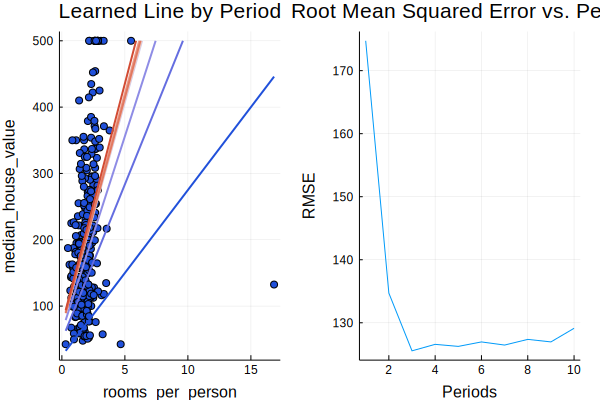

In [15]:
plot(p1, p2, layout=(1,2), legend=false)

## Task 2: Identify Outliers

We can visualize the performance of our model by creating a scatter plot of predictions vs. target values.  Ideally, these would lie on a perfectly correlated diagonal line.

We use `scatter` to create a scatter plot of predictions vs. targets, using the rooms-per-person model you trained in Task 1.

Do you see any oddities?  Trace these back to the source data by looking at the distribution of values in `rooms_per_person`.

In [30]:
scatter(calibration_data[:predictions], calibration_data[:targets], legend=false)

The calibration data shows most scatter points aligned to a line. The line is almost vertical, but we'll come back to that later. Right now let's focus on the ones that deviate from the line. We notice that they are relatively few in number.

If we plot a histogram of `rooms_per_person`, we find that we have a few outliers in our input data:

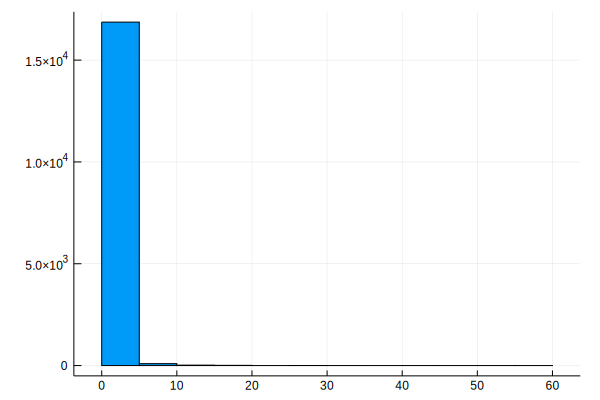

In [17]:
histogram(california_housing_dataframe[:rooms_per_person], nbins=20, legend=false)

## Task 3: Clip Outliers

We see if we can further improve the model fit by setting the outlier values of `rooms_per_person` to some reasonable minimum or maximum.

The histogram we created in Task 2 shows that the majority of values are less than `5`. Let's clip `rooms_per_person` to 5, and plot a histogram to double-check the results.

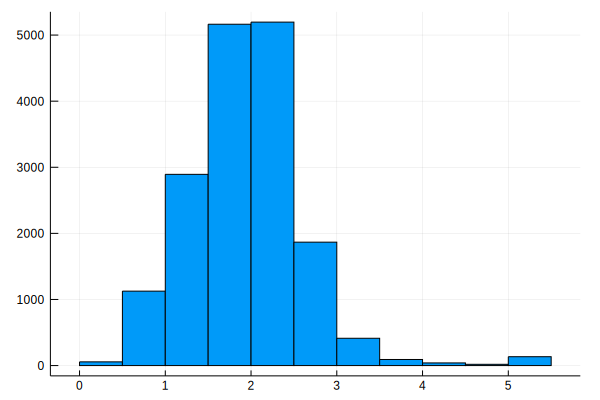

In [18]:
california_housing_dataframe[:rooms_per_person] = min.(
    california_housing_dataframe[:rooms_per_person],5)

histogram(california_housing_dataframe[:rooms_per_person], nbins=20, legend=false)

To verify that clipping worked, let's train again and print the calibration data once more:

In [23]:
p1, p2, calibration_data= train_model(
    0.05, # learning rate
    500, # steps
    10, # batch size
    :rooms_per_person #feature
)

Training model...
RMSE (on training data):
  period 1: 204.65393150901195
  period 2: 173.7183427312223
  period 3: 145.97809305428905
  period 4: 123.6036198238067
  period 5: 112.8142399617989
  period 6: 108.63058108212915
  period 7: 107.55735462898159
  period 8: 107.53097708301351
  period 9: 107.5025442282244
  period 10: 107.44954799028854
Model training finished.


(Plot{Plots.GRBackend() n=11}, Plot{Plots.GRBackend() n=1}, 17000×2 DataFrames.DataFrame
│ Row   │ predictions │ targets │
├───────┼─────────────┼─────────┤
│ 1     │ 413.677     │ 66.9    │
│ 2     │ 413.677     │ 80.1    │
│ 3     │ 217.866     │ 85.7    │
│ 4     │ 269.782     │ 73.4    │
│ 5     │ 229.456     │ 65.5    │
│ 6     │ 211.305     │ 74.0    │
│ 7     │ 177.63      │ 82.4    │
│ 8     │ 218.085     │ 48.5    │
│ 9     │ 174.115     │ 58.4    │
│ 10    │ 199.926     │ 48.1    │
│ 11    │ 174.728     │ 86.5    │
⋮
│ 16989 │ 200.584     │ 66.9    │
│ 16990 │ 204.229     │ 58.1    │
│ 16991 │ 204.107     │ 78.3    │
│ 16992 │ 230.979     │ 73.2    │
│ 16993 │ 209.721     │ 50.8    │
│ 16994 │ 230.037     │ 106.7   │
│ 16995 │ 296.027     │ 76.1    │
│ 16996 │ 237.335     │ 111.4   │
│ 16997 │ 204.423     │ 79.0    │
│ 16998 │ 217.16      │ 103.6   │
│ 16999 │ 210.717     │ 85.8    │
│ 17000 │ 224.484     │ 94.6    │)

Final RMSE (on training data): 107.44954799028854
Final Weight (on training data): 69.0
Final Bias (on training data): 68.67712220400571


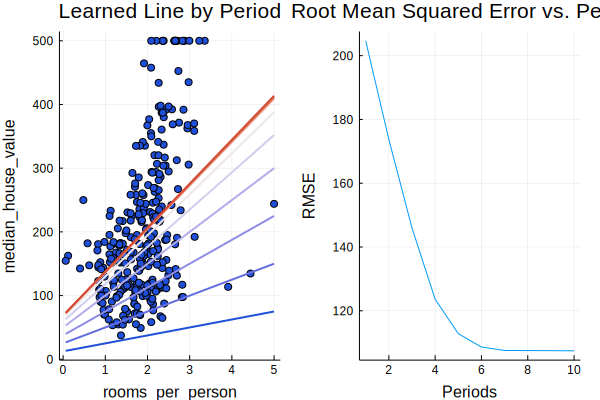

In [24]:
plot(p1, p2, layout=(1,2), legend=false)

In [29]:
scatter(calibration_data[:predictions], calibration_data[:targets], legend=false)

In [25]:
# end of file